In [1]:
! pip install ogb

In [2]:
from ogb.nodeproppred import NodePropPredDataset

dataset = NodePropPredDataset(name="ogbn-arxiv")



c:\Users\annak\anaconda3\lib\site-packages\torch\_weights_only_unpickler.py:549: UserWarning: Detected pickle protocol 4 in the checkpoint, which was not the default pickle protocol used by `torch.load` (2). The weights_only Unpickler might not support all instructions implemented by this protocol, please file an issue for adding support if you encounter this.
  warnings.warn(


UnpicklingError: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: Unsupported operand 149

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:

import networkx as nx

dataset = NodePropPredDataset(name="ogbn-arxiv")
graph, labels = dataset[0]
edge_index = graph['edge_index']        # shape [2, num_edges]
label_idx  = labels.flatten()           # shape [num_nodes]


G = nx.DiGraph()
edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
G.add_edges_from(edges)

unique_labels = sorted(set(label_idx.tolist()))
print("Available topics:", unique_labels[:10], "… total", len(unique_labels))


for k in unique_labels[:5]:   # τα πρώτα 5 topics
    # personalization vector: 1 αν node έχει label==k, αλλιώς 0
    pers = {i: (1 if label_idx[i]==k else 0) for i in range(len(label_idx))}
    s = sum(pers.values())
    if s == 0:
        print(f"Topic {k}: no nodes → skip")
        continue
    pers = {i: v/s for i,v in pers.items()}

    pr = nx.pagerank(G, alpha=0.85, personalization=pers)
    top10 = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop-10 papers for topic {k}:")
    for nid, score in top10:
        print(f"  Node {nid}  PR={score:.4e}")


Available topics: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] … total 40

Top-10 papers for topic 0:
  Node 146548  PR=1.2377e-02
  Node 159030  PR=8.2221e-03
  Node 92164  PR=6.8955e-03
  Node 13954  PR=6.5938e-03
  Node 158460  PR=6.0242e-03
  Node 88803  PR=5.9292e-03
  Node 138634  PR=5.7643e-03
  Node 16921  PR=4.3020e-03
  Node 155813  PR=3.8793e-03
  Node 101499  PR=3.5264e-03

Top-10 papers for topic 1:
  Node 159030  PR=1.2130e-02
  Node 88803  PR=1.1953e-02
  Node 125272  PR=8.5714e-03
  Node 14201  PR=8.0809e-03
  Node 25208  PR=6.8893e-03
  Node 98786  PR=6.4950e-03
  Node 158981  PR=5.7792e-03
  Node 46132  PR=5.5715e-03
  Node 22035  PR=5.3852e-03
  Node 22502  PR=5.2213e-03

Top-10 papers for topic 2:
  Node 159030  PR=7.8389e-03
  Node 88803  PR=5.3131e-03
  Node 147980  PR=3.7060e-03
  Node 18349  PR=2.8680e-03
  Node 14201  PR=2.8348e-03
  Node 125272  PR=2.6620e-03
  Node 95634  PR=2.6109e-03
  Node 42168  PR=2.0691e-03
  Node 109295  PR=1.8701e-03
  Node 134699  PR=1.8354e-03

T

In [ ]:
# Global PageRank (χωρίς personalization)
global_pr = nx.pagerank(G, alpha=0.85)

# Top-20 global leaders
top_k = 20
global_top = [nid for nid, _ in 
              sorted(global_pr.items(), key=lambda x: x[1], reverse=True)[:top_k]]

print("Top-20 global PageRank nodes:", global_top)


Top-20 global PageRank nodes: [88803, 159030, 125272, 14201, 1353, 46132, 25208, 22502, 22035, 98786, 94874, 7805, 33955, 93649, 58062, 67166, 94832, 125219, 51364, 106699]


In [ ]:
import pandas as pd

jaccard = {}
overlap = {}

for k in unique_labels:

    pers = {i: (1 if label_idx[i]==k else 0) for i in range(len(label_idx))}
    total = sum(pers.values())
    if total == 0:
        continue
    pers = {i: v/total for i,v in pers.items()}
    
    pr_t = nx.pagerank(G, alpha=0.85, personalization=pers)
    topic_top = [nid for nid,_ in 
                 sorted(pr_t.items(), key=lambda x: x[1], reverse=True)[:top_k]]
    
    set_g, set_t = set(global_top), set(topic_top)
    inter = len(set_g & set_t)
    union = len(set_g | set_t)
    jaccard[k] = inter/union
    overlap[k] = inter


df = pd.DataFrame({
    'topic': list(jaccard.keys()),
    'jaccard': list(jaccard.values()),
    'overlap': list(overlap.values())
}).set_index('topic')

print(df.head())


        jaccard  overlap
topic                   
0      0.111111        4
1      0.538462       14
2      0.176471        6
3      0.428571       12
4      0.333333       10


In [ ]:
import matplotlib.pyplot as plt



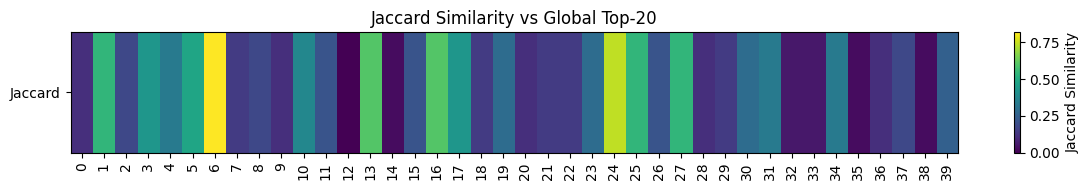

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))
im = plt.imshow([df['jaccard']], aspect='auto', cmap='viridis')

plt.colorbar(im, orientation='vertical', label='Jaccard Similarity')
plt.yticks([0], ['Jaccard'])
plt.xticks(range(len(df)), df.index, rotation=90)
plt.title('Jaccard Similarity vs Global Top-20')
plt.tight_layout()
plt.show()


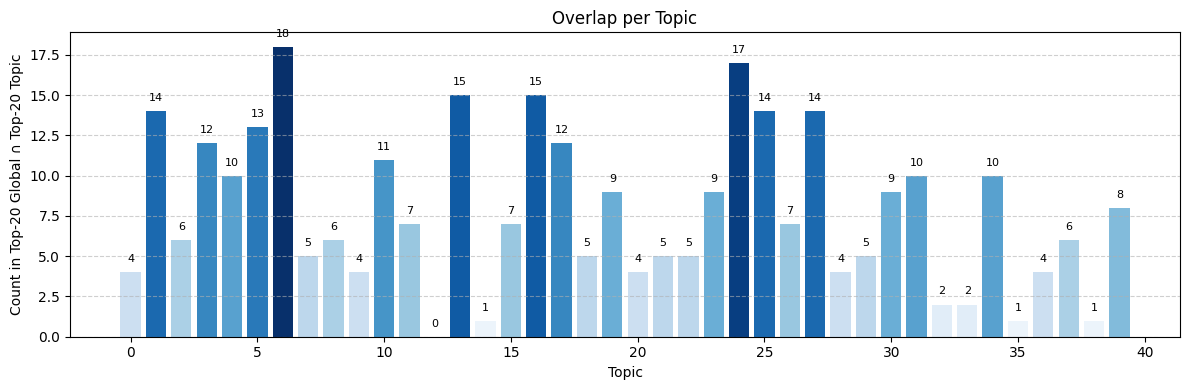

In [ ]:
plt.figure(figsize=(12, 4))
bars = plt.bar(df.index, df['overlap'], color=plt.cm.Blues(df['overlap'] / df['overlap'].max()))
plt.xlabel('Topic')
plt.ylabel('Count in Top-20 Global ∩ Top-20 Topic')
plt.title('Overlap per Topic')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Προσθήκη τιμής πάνω σε κάθε bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


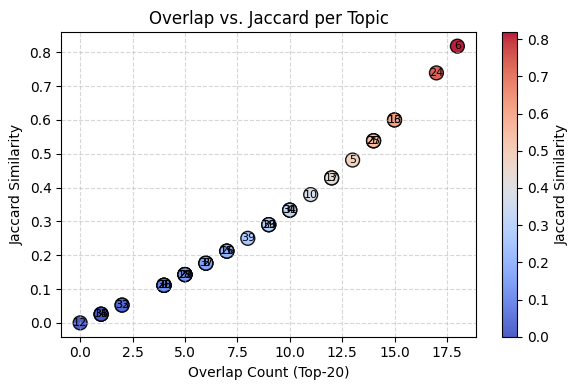

In [ ]:

plt.figure(figsize=(6,4))
sc = plt.scatter(
    df['overlap'],
    df['jaccard'],
    c=df['jaccard'],
    cmap='coolwarm',     # πιο φωτεινό colormap
    s=100,
    edgecolor='black',
    alpha=0.9             # πιο διαφανές
)

# Ετικέτες
for topic, row in df.iterrows():
    plt.text(row['overlap'], row['jaccard'], str(topic), fontsize=8, ha='center', va='center')

plt.xlabel('Overlap Count (Top-20)')
plt.ylabel('Jaccard Similarity')
plt.title('Overlap vs. Jaccard per Topic')
plt.colorbar(sc, label='Jaccard Similarity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
df_labels = pd.read_csv("labelidx2arxivcategeory.csv.gz")
print(df_labels.columns)

Index(['label idx', 'arxiv category'], dtype='object')


In [ ]:
label_dict = dict(zip(df_labels['label idx'], df_labels['arxiv category']))


for k in sorted(label_dict):
    print(f"{k}: {label_dict[k]}")


0: arxiv cs na
1: arxiv cs mm
2: arxiv cs lo
3: arxiv cs cy
4: arxiv cs cr
5: arxiv cs dc
6: arxiv cs hc
7: arxiv cs ce
8: arxiv cs ni
9: arxiv cs cc
10: arxiv cs ai
11: arxiv cs ma
12: arxiv cs gl
13: arxiv cs ne
14: arxiv cs sc
15: arxiv cs ar
16: arxiv cs cv
17: arxiv cs gr
18: arxiv cs et
19: arxiv cs sy
20: arxiv cs cg
21: arxiv cs oh
22: arxiv cs pl
23: arxiv cs se
24: arxiv cs lg
25: arxiv cs sd
26: arxiv cs si
27: arxiv cs ro
28: arxiv cs it
29: arxiv cs pf
30: arxiv cs cl
31: arxiv cs ir
32: arxiv cs ms
33: arxiv cs fl
34: arxiv cs ds
35: arxiv cs os
36: arxiv cs gt
37: arxiv cs db
38: arxiv cs dl
39: arxiv cs dm
